# 마스크 착용 상태 분류 대회
COVID-19의 확산으로 우리나라는 물론 전 세계 사람들은 경제적, 생산적인 활동에 많은 제약을 가지게 되었습니다. 우리나라는 COVID-19 확산 방지를 위해 사회적 거리 두기를 단계적으로 시행하는 등의 많은 노력을 하고 있습니다. 과거 높은 사망률을 가진 사스(SARS)나 에볼라(Ebola)와는 달리 COVID-19의 치사율은 오히려 비교적 낮은 편에 속합니다. 그럼에도 불구하고, 이렇게 오랜 기간 동안 우리를 괴롭히고 있는 근본적인 이유는 바로 COVID-19의 강력한 전염력 때문입니다.

감염자의 입, 호흡기로부터 나오는 비말, 침 등으로 인해 다른 사람에게 쉽게 전파가 될 수 있기 때문에 감염 확산 방지를 위해 무엇보다 중요한 것은 모든 사람이 마스크로 코와 입을 가려서 혹시 모를 감염자로부터의 전파 경로를 원천 차단하는 것입니다. 이를 위해 공공 장소에 있는 사람들은 반드시 마스크를 착용해야 할 필요가 있으며, 무엇 보다도 코와 입을 완전히 가릴 수 있도록 올바르게 착용하는 것이 중요합니다. 하지만 넓은 공공장소에서 모든 사람들의 올바른 마스크 착용 상태를 검사하기 위해서는 추가적인 인적자원이 필요할 것입니다.

따라서, 우리는 카메라로 비춰진 사람 얼굴 이미지 만으로 이 사람이 마스크를 쓰고 있는지, 쓰지 않았는지, 정확히 쓴 것이 맞는지 자동으로 가려낼 수 있는 시스템이 필요합니다. 이 시스템이 공공장소 입구에 갖춰져 있다면 적은 인적자원으로도 충분히 검사가 가능할 것입니다.



## Problem Definition (문제 정의)
마스터님의 말씀을 따라 문제 정의부터 해보겠습니다.

- 내가 지금 풀어야할 문제가 무엇인가?
    - 이미지가 주어졌을 때, 마스크 착용 여부, 나이, 성별을 구분하여 정해진 라벨을 반환해야한다.
    - 3가지를 각각 분류해주는 것과, 한번에 분류해주는 법 2가지로 문제를 해결할 수 있을 것입니다.
- 이 문제의 Input과 Output은 무엇인가?
    - Input은 Image, Output은 18개의 클래스 중 하나
- 이 솔루션은 어디서 어떻게 사용되어지는가?
    - 공공장소 등 마스크 검사가 필요한 많은 곳에서 불필요한 자원 감소를 위해 사용될 것이다.

# Data Load & EDA 
* 데이터에 대해 파악해보겠습니다.

## Data Load

In [2]:
# 한글 폰트 사용
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager as fm
import os

def change_matplotlib_font(font_download_url):
    FONT_PATH = 'MY_FONT'
    
    font_download_cmd = f"wget {font_download_url} -O {FONT_PATH}.zip"
    unzip_cmd = f"unzip -o {FONT_PATH}.zip -d {FONT_PATH}"
    os.system(font_download_cmd)
    os.system(unzip_cmd)
    
    font_files = fm.findSystemFonts(fontpaths=FONT_PATH)
    for font_file in font_files:
        fm.fontManager.addfont(font_file)

    font_name = fm.FontProperties(fname=font_files[2]).get_name()
    matplotlib.rc('font', family=font_name)
    print("font family: ", plt.rcParams['font.family'])

font_download_url = "https://fonts.google.com/download?family=Nanum%20Gothic"
change_matplotlib_font(font_download_url)
# 마이너스 폰트 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

--2021-08-28 06:13:55--  https://fonts.google.com/download?family=Nanum%20Gothic
Resolving fonts.google.com (fonts.google.com)... 172.217.161.46, 2404:6800:4004:80a::200e
Connecting to fonts.google.com (fonts.google.com)|172.217.161.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘MY_FONT.zip’

     0K .......... .......... .......... .......... ..........  738K
    50K .......... .......... .......... .......... .......... 1.47M
   100K .......... .......... .......... .......... .......... 2.34M
   150K .......... .......... .......... .......... .......... 3.55M
   200K .......... .......... .......... .......... .......... 4.01M
   250K .......... .......... .......... .......... .......... 4.91M
   300K .......... .......... .......... .......... .......... 5.75M
   350K .......... .......... .......... .......... .......... 7.11M
   400K .......... .......... .......... .......... .......... 7.93M
   450K .....

Archive:  MY_FONT.zip
  inflating: MY_FONT/OFL.txt         
  inflating: MY_FONT/NanumGothic-Regular.ttf  
  inflating: MY_FONT/NanumGothic-Bold.ttf  
  inflating: MY_FONT/NanumGothic-ExtraBold.ttf  
font family:  ['NanumGothic']


In [1]:
import pandas as pd

# meta 데이터와 이미지 경로를 불러옵니다.
train_path = '/opt/ml/image-classification-level1-12/templates/data/train'
train_df = pd.read_csv(os.path.join(train_path, 'train.csv'))

* 다행이도 Null 값은 존재하지 않습니다.
* 하지만 여기서 가장 큰 문제가 발생합니다. 바로 라벨링이 되어 있지 않다는 것
	* 심지어 이미지 개수와도 다른 문제가 있었습니다. 아래 코드 공유를 참고하여 해결했습니다
	* https://stages.ai/competitions/74/discussion/post/431

## EDA

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2700 non-null   object
 1   gender  2700 non-null   object
 2   race    2700 non-null   object
 3   age     2700 non-null   int64 
 4   path    2700 non-null   object
dtypes: int64(1), object(4)
memory usage: 105.6+ KB


* 인종은 Asian뿐 -> 제거
* gender와 age는 class에 맞춰 category화
* id의 경우 중복이 있음 -> 알아두자

In [4]:
train_df.describe(include='all')

,id,gender,race,age,path
count,2700,2700,2700,2700.000000,2700
unique,2699,2,1,NaN,2700
top,003397,female,Asian,NaN,006926_male_Asian_19
freq,2,1658,2700,NaN,1
mean,NaN,NaN,NaN,37.708148,NaN
std,NaN,NaN,NaN,16.985904,NaN
min,NaN,NaN,NaN,18.000000,NaN
25%,NaN,NaN,NaN,20.000000,NaN
50%,NaN,NaN,NaN,36.000000,NaN
75%,NaN,NaN,NaN,55.000000,NaN


* 데이터가 굉장히 극단적이고, 30대 미만은 구분하기 쉽지만, 50대와 60대는 구분하기 어려울 것 같습니다.

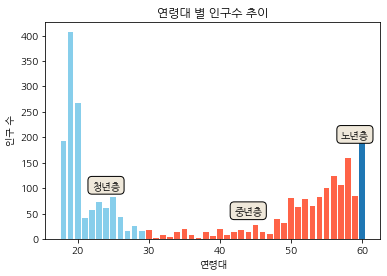

In [5]:
plt.bar(train_df.age.value_counts().index, train_df.age.value_counts(), color='tomato')
plt.bar(train_df.age.value_counts().sort_index()[:12].index, train_df.age.value_counts().sort_index()[:12], color='skyblue')
plt.bar(train_df.age.value_counts().sort_index()[-1:].index, train_df.age.value_counts().sort_index()[-1:])
plt.annotate('청년층', (22, 100), fontsize=10, bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8da', linewidth=1))
plt.annotate('중년층', (42, 50), fontsize=10, bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8da', linewidth=1))
plt.annotate('노년층', (57, 200), fontsize=10, bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8da', linewidth=1))
plt.xlabel('연령대')
plt.ylabel('인구 수')
plt.title('연령대 별 인구수 추이')
plt.show()

In [6]:
train_df.drop(columns='race', inplace=True)
train_df['gender'] = train_df['gender'].map(lambda x: 0 if x=='female' else 1)
train_df['age'] = train_df['age'].map(lambda x: 0 if x<30 else (1 if x<60 else 2))
train_df['class'] = train_df.apply(lambda x: str(x['gender'])+'_'+str(x['age']), axis=1)

* 마찬가지로 데이터가 굉장히 imbalanced함을 확인할 수 있었습니다. -> 이 부분 해결 필요!
* 여성의 경우 남성보다 데이터가 많고, 청년층과 중년층의 순위도 두 그룹이 다릅니다.

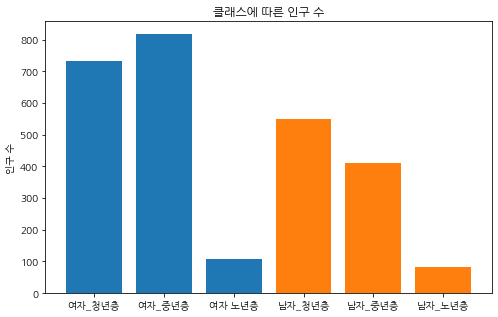

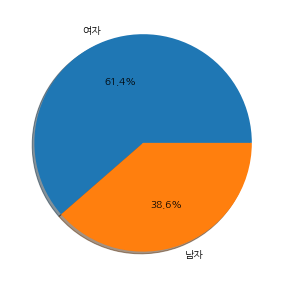

In [7]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8, 5))

class_viz = train_df.groupby('class').count()['id']
ax1.bar(class_viz.index, class_viz.values)
ax1.bar(class_viz.index[3:], class_viz.values[3:])
class_labels = ['여자_청년층', '여자_중년층', '여자 노년층', '남자_청년층', '남자_중년층', '남자_노년층']
ax1.set_xticklabels(class_labels)
ax1.set_ylabel('인구 수')
ax1.set_title('클래스에 따른 인구 수')

fig2, ax2 = plt.subplots(figsize=(5, 5))
ax2.pie(train_df.groupby(['gender']).count()['id'], labels=['여자', '남자'], 
		shadow=True, autopct='%1.1f%%')


plt.show()

## Data_labeling.py

In [31]:
import os

import pandas as pd
import tqdm


class Make_Label:
    def __init__(self, BASE_PATH: str, CSV_FILE: pd.DataFrame, COLS: list):
        """
        기존의 train.csv 파일에 labeling을 새로 해주기 위해 경로 설정
        Args:
            BASE_PATH (str): train.csv File path
            CSV_FILE (pd.DataFrame): train.csv
            COLS (list): 새로 만들 DataFrame의 COLUMN
        """
        self.path = BASE_PATH
        self.img_path = os.path.join(BASE_PATH, "images")
        self.csv_file = CSV_FILE
        self.df = pd.DataFrame(columns=COLS)

    def labeling(self):
        idx_df = 0
        # 이미지 폴더 path
        for idx in tqdm.tqdm(range(train_df.shape[0])):
            IMG_PATH = os.path.join(self.img_path, train_df.iloc[idx]["path"])
            file_list = os.listdir(IMG_PATH)

            for file in file_list:
                if file.rstrip().startswith("._"):  # ._{파일명} 제거
                    continue

                file_path = os.path.join(IMG_PATH, file)
                # train.csv 파일에서 gender, age 정보를 가져옴
                self.df.loc[idx_df] = train_df.loc[idx][["gender", "age"]]
                # image 파일 전체 경로, 이름
                self.df.loc[idx_df][["path", "name"]] = [
                    file_path,
                    file_path.split("/")[-2] + "_" + file,
                ]
                self.check_label(self.df, idx_df)
                idx_df += 1

        # 새로 만든 DataFrame 저장
        labeling_data_path = "/opt/ml/image-classification-level1-12/templates/data/train/train_with_label.csv"
        self.df.to_csv(labeling_data_path, index=False)

    # 대회 기준에 맞춰서 label 부여
    # 여자일 경우+3, 마스크 착용 상태가 incorrect+6, Normal+12
    def check_label(self, df, idx_df):
        mask = df.loc[idx_df]["name"]
        gender = df.loc[idx_df]["gender"]
        age = df.loc[idx_df]["age"]

        if age < 30:
            label = 0
        elif 30 <= age < 60:
            label = 1
        else:
            label = 2
        if gender == "female":
            label += 3
        if "incorrect" in mask:
            label += 6
        elif "normal" in mask:
            label += 12

        df.loc[idx_df]["label"] = label


if __name__ == "__main__":
    # train 데이터 경로 지정
    train_path = "/opt/ml/image-classification-level1-12/templates/data/train"
    # train 데이터를 데이터프레임 형태로
    train_df = pd.read_csv(os.path.join(train_path, "train.csv"))

    # labeling 시행
    make_label = Make_Label(
        train_path, train_df, ["gender", "age", "path", "name", "label"]
    )
    make_label.labeling()

    # 에러 데이터 처리 코드 -> 결과가 오히려 안좋아져서 보류
    # df = pd.read_csv('/opt/ml/image-classification-level1-12/templates/data/train/train_with_label.csv')

    # df['error_check'] = df['name'].map(lambda x : 1
    #             if ('006359' in x or '006360' in x or '006361' in x or '006362' in x or '006363' in x or '006364' in x)
    #             else (2 if ('001498-1' in x or '004432' in x)
    #             else (3 if ('000020' in x or '004418' in x or '005227' in x) and ('incorrect'  in x or 'normal'in x) else 0)))

    # df['label'] = df.apply(lambda x: x['label']-3 if x['error_check']==1
    #                             else (x['label']+3 if x['error_check']==2
    #                             else (x['label']+6 if (x['error_check']==3 and 'incorrect' in x['name'])
    #                             else (x['label']-6 if (x['error_check']==3 and 'normal' in x['name']) else x['label']))), axis=1)

    # df.drop(columns=['error_check'], inplace=True)
    # df.to_csv("/opt/ml/image-classification-level1-12/templates/data/train/train_with_label.csv", index=False)


100%|██████████| 2700/2700 [01:42<00:00, 26.29it/s]


In [8]:
train_label = pd.read_csv(os.path.join(train_path, 'train_with_label.csv'))

* labeling이 잘 된 것을 확인할 수 있다

In [9]:
train_label.sample(5)

,gender,age,path,name,label
5141,female,60,/opt/ml/image-classification-level1-12/templat...,001468_female_Asian_60_mask4.jpg,5
6293,female,35,/opt/ml/image-classification-level1-12/templat...,001652_female_Asian_35_mask2.jpg,4
14204,female,54,/opt/ml/image-classification-level1-12/templat...,005106_female_Asian_54_incorrect_mask.jpg,10
18052,male,20,/opt/ml/image-classification-level1-12/templat...,006616_male_Asian_20_mask4.jpeg,0
8158,female,20,/opt/ml/image-classification-level1-12/templat...,003119_female_Asian_20_mask4.jpg,3


* 이미지 총 개수와 동일함을 알 수 있다

In [10]:
train_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   gender  18900 non-null  object
 1   age     18900 non-null  int64 
 2   path    18900 non-null  object
 3   name    18900 non-null  object
 4   label   18900 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 738.4+ KB


In [11]:
train_label.describe(include='all')

,gender,age,path,name,label
count,18900,18900.000000,18900,18900,18900.000000
unique,2,NaN,18900,18900,NaN
top,female,NaN,/opt/ml/image-classification-level1-12/templat...,003373_female_Asian_20_mask3.jpg,NaN
freq,11606,NaN,1,1,NaN
mean,NaN,37.708148,NaN,NaN,5.010317
std,NaN,16.983208,NaN,NaN,4.660533
min,NaN,18.000000,NaN,NaN,0.000000
25%,NaN,20.000000,NaN,NaN,1.000000
50%,NaN,36.000000,NaN,NaN,4.000000
75%,NaN,55.000000,NaN,NaN,7.000000


* 5:1:1 비율로 정확히 생성됨

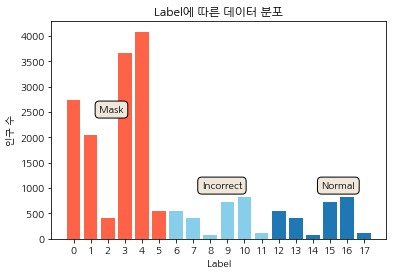

In [12]:
label_data = train_label.groupby('label').count()['gender']
plt.bar(label_data.index, label_data, color='tomato')
plt.bar(label_data[6:12].index, label_data[6:12], color='skyblue')
plt.bar(label_data[12:].index, label_data[12:])
plt.xticks(label_data.index)
plt.annotate('Mask', (1.5, 2500), fontsize=10, bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8da', linewidth=1))
plt.annotate('Incorrect', (7.5, 1000), fontsize=10, bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8da', linewidth=1))
plt.annotate('Normal', (14.5, 1000), fontsize=10, bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8da', linewidth=1))
plt.xlabel('Label')
plt.ylabel('인구 수')
plt.title('Label에 따른 데이터 분포')
plt.show()

# Data Split
* 이제 라벨링을 완료했으니 학습을 시켜줘야 합니다. 
* 학습을 위해선 train과 validation set을 분리시켜줘야합니다
	* 여러 방법이 있지만 저는 data balance를 지켜주기 위해 StratifiedKFold를 사용하겠습니다

In [48]:
import argparse
import os
import random
import shutil

import numpy as np
import pandas as pd
import tqdm
from sklearn.model_selection import StratifiedKFold
from utils.util import ensure_dir

random_seed = 12
np.random.seed(random_seed)
random.seed(random_seed)


class Run_Split:
    def __init__(self, dirname):
        self.dirname = dirname

    def image_all(self, df: pd.DataFrame, df_name: str):
        """
        train dataset을 train, val에 맞춰서 폴더 재생성

        Args:
        dirname (str): '/opt/ml/image-classification-level1-12/templates/data/train/image_all'
        df (pd.DataFrame): train_df와 val_df
        df_name (str): 입력된 df에 맞춰서 입력
        """
        dirname = os.path.join(self.dirname, df_name)
        # 빈 directory 생성
        ensure_dir(dirname)

        for idx in range(len(df)):
            path = df["path"][idx]
            name = df["name"][idx]
            shutil.copy(path, os.path.join(dirname, name))

    def train_val_split(self, train_label, fold_num):
        KFold = StratifiedKFold(fold_num)
        X = train_label.index
        y = train_label["label"]

        train_list, val_list = [], []

        for train_idx, val_idx in KFold.split(X, y):
            train_list.append(
                train_label[train_label.index.isin(X[train_idx])].reset_index(drop=True)
            )
            val_list.append(
                train_label[train_label.index.isin(X[val_idx])].reset_index(drop=True)
            )

        return train_list, val_list


if __name__ == "__main__":
    args = argparse.ArgumentParser(description="PyTorch Template")
    args.add_argument(
        "--train_path",
        default="/opt/ml/image-classification-level1-12/templates/data/train",
        type=str,
        help="train_path",
    )
    args.add_argument("--fold_num", default=5, type=int, help="kfold_num")

    args = args.parse_args()

    train_path = args.train_path
    train_label = pd.read_csv(os.path.join(train_path, "train_with_label.csv"))
    run_train = Run_Split(os.path.join(train_path, "image_all"))
    fold_num = args.fold_num
    train_list, val_list = run_train.train_val_split(train_label, fold_num)

    for i in tqdm.tqdm(range(fold_num)):
        run_train.image_all(train_list[i], f"train{i}_image")
        run_train.image_all(val_list[i], f"val{i}_image")

100%|██████████| 5/5 [00:26<00:00,  5.34s/it]


# Train Process
* 이제 데이터를 본격적으로 학습시켜볼텐데요 저는 가장 익숙한 Resnet18 model을 사용해 학습해보겠습니다.

## Import Libaray


In [69]:
import argparse
import datetime as dt
import math
import os
import random
import time
from functools import partial
from pathlib import Path

import albumentations
import albumentations.pytorch
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tqdm
from PIL import Image
from pytz import timezone
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18
from torchvision.models.resnet import resnet50, resnet152
from torchvision.transforms import Normalize, Resize, ToTensor
from torchvision.transforms.transforms import GaussianBlur, RandomRotation

from data_preprocessing.data_split import Run_Split
from model.loss import batch_loss
from model.metric import batch_acc, batch_f1, epoch_mean
from model.model import resnet_finetune
from utils.util import ensure_dir, notification, prepare_device

## Model 
* Resnet18 Model의 경우에는 FC layer가 512개의 feature를 가지고 있습니다
	* 우리가 원하는 18개의 Class로 분류해주기 위해 model.fc를 설정해줍니다

In [51]:
def resnet_finetune(model, classes):
    """
    resnet model명과 output class 개수를 입력해주면
    그것에 맞는 모델을 반환, pretrained, bias initialize
    """

    model = model(pretrained=True)
    # for params in model.parameters():
    #     params.requires_grad = False
    # model.fc = nn.Linear(in_features=512, out_features=classes, bias=True)

    # print("네트워크 필요 입력 채널 개수", model.conv1.weight.shape[1])
    # print("네트워크 출력 채널 개수 (예측 class type 개수)", model.fc.weight.shape[0])

    # torch.nn.init.xavier_uniform_(model.fc.weight)
    # stdv = 1.0 / math.sqrt(model.fc.weight.size(1))
    # model.fc.bias.data.uniform_(-stdv, stdv)

    model.fc = nn.Linear(in_features=512, out_features=128, bias=True)
    model.bc = nn.BatchNorm2d(
        128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    )
    model.relu = nn.ReLU(inplace=True)
    model.dropout = nn.Dropout(p=0.2)
    model.fc2 = nn.Linear(in_features=128, out_features=classes, bias=True)

    print("네트워크 필요 입력 채널 개수", model.conv1.weight.shape[1])
    print("네트워크 출력 채널 개수 (예측 class type 개수)", model.fc2.weight.shape[0])

    nn.init.xavier_uniform_(model.fc2.weight)
    stdv = 1.0 / math.sqrt(model.fc2.weight.size(1))
    model.fc2.bias.data.uniform_(-stdv, stdv)

    return model


네트워크 필요 입력 채널 개수 3
네트워크 출력 채널 개수 (예측 class type 개수) 18


## Train Dataset

In [53]:
class Mask_Dataset(object):
    def __init__(self, transforms, name, df, path):
        self.transforms = transforms
        self.name = name
        self.path = path
        self.imgs = sorted(
            os.listdir(os.path.join(self.path, f"image_all/{self.name}_image"))
        )
        self.df = df

    def __getitem__(self, idx):
        # img_path = Path(self.df["path"][idx])
        img_path = self.df["path"][idx]
        target = self.df["label"][idx]

        # img = cv2.imread(img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # if self.transforms is not None:
        #     augmented = self.transforms(image = img)
        #     img = augmented['image']

        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

## 학습 파라미터 설정

In [64]:
# 데이터 분리 과정
run_split = Run_Split(os.path.join(train_path, "image_all"))
train_list, val_list = run_split.train_val_split(train_label)

# 학습 때 GPU 사용여부 결정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 데이터 변환
data_transform = transforms.Compose([ToTensor()])

# 학습률
LEARNING_RATE = 0.01
NUM_EPOCH = 5

# 모델 할당
my_resnet = resnet_finetune(resnet18, 18).to(device)

# 분류 학습 때 많이 사용되는 Cross entropy loss
loss_fn = (torch.nn.CrossEntropyLoss())

# weight 업데이트를 위한 optimizer를 Adam으로 사용함
optimizer = torch.optim.Adam(my_resnet.parameters(), lr=LEARNING_RATE)  


네트워크 필요 입력 채널 개수 3
네트워크 출력 채널 개수 (예측 class type 개수) 18


## Data loader

In [63]:
train_dataset = Mask_Dataset(data_transform, "train0", train_list[0])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4)

val_dataset = Mask_Dataset(data_transform, f"val0", val_list[0])
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4)

dataloaders = {"train": train_loader, "test": val_loader}

## Model Train

In [ ]:
### 학습 코드 시작
for epoch in range(NUM_EPOCH):
	for phase in ["train", "test"]:
		running_loss = 0.0
		running_acc = 0.0
		if phase == "train":
			my_resnet.train()  # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
		elif phase == "test":
			my_resnet.eval()  # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함
		
		# 배치 단위로 data load하여서 작업 -> 이때 transpose 및 여러 함수가 적용된다.
		for ind, (images, labels) in enumerate(tqdm.tqdm(dataloaders[phase], leave=False)):
			images = torch.stack(list(images), dim=0).to(device)
			labels = torch.tensor(list(labels)).to(device)

			optimizer.zero_grad()  # parameter gradient를 업데이트 전 초기화함

			with torch.set_grad_enabled(
				phase == "train"
			):  # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
				logits = my_resnet(images)
				_, preds = torch.max(
					logits, 1
				) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함
				loss = loss_fn(logits, labels)

				if phase == "train":
					loss.backward()  # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
					optimizer.step()  # 계산된 gradient를 가지고 모델 업데이트

			running_loss += loss.item() * images.size(0)  # 한 Batch에서의 loss 값 저장
			running_acc += torch.sum(
				preds == labels.data
			)  # 한 Batch에서의 Accuracy 값 저장

		# 한 epoch이 모두 종료되었을 때,
		epoch_loss = running_loss / len(dataloaders[phase].dataset)
		epoch_acc = running_acc / len(dataloaders[phase].dataset)

		print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
print("학습 종료!")

# Test Process
* 이제 학습이 완료된 Model을 가지고 Test를 예측해보죠! 거의 다 했습니다.!

## Test Dataset

In [70]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [71]:
# Test image path 설정
test_dir = "/opt/ml/pytorch-template/input/data/eval"
submission = pd.read_csv(os.path.join(test_dir, "info.csv"))
image_dir = os.path.join(test_dir, "images")

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

# Test Dataset을 위한 준비 작업
transform = transforms.Compose([ToTensor()])
dataset = TestDataset(image_paths, transform)
loader = DataLoader(dataset, shuffle=False)

## Model Test
* 다음 코드를 실행해주면 우리의 작업은 완료가 됩니다.
* 이제 파일을 다운받아 제출해보시죠!

In [73]:
all_predictions = []
my_resnet.eval()
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = my_resnet(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions
print("test inference is done!")
submission

test inference is done!


,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,9
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,9
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,9
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,9
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,9
...,...,...
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,15
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,9
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,9
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,3
